In [1]:
"""
Created on 25/02/22

Compare Lyapunov exponant of Lorenz system VS SINDy prediction horizon.

We will complete a paramater sweep to collect a wide range of Lyapunov exponants.
For each of these paramater combinations, we will also construct a SINDy model 
based on some fixed amount of training data. We will then simulate the true model
and the SINDy model and note the time it diverges by a fixed amount. We will then
compare the Lyapunov exponant and the divergance time for each system.


Author: Patrick Munnelly

"""
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos
from scipy.integrate import solve_ivp
import seaborn as sns
import pysindy as ps

In [2]:
##############################################################################
# Define initial condition and paramater sweep range values:
    
X0 = [8,7,15]

s_omega = np.arange(13, 17, 0.2)
s_Lambda = np.arange(23, 27, 0.2)

sigma = 10
rho = 28
beta = 8/3

In [3]:
##############################################################################
# Set SINDy training and test paramaters:

dt = 0.01 # Set timestep for integration
t_train = np.arange(0, 10, dt)  # Time range to integrate over
x0_train = [-8, 8, 27]  # Initial Conditions

t_test = np.arange(0, 50, dt)  # Longer time range
x0_test = X0 #np.array([8, 7, 15])  # New initial conditions

diverge_time = np.full((s_omega.size, s_Lambda.size), t_test[-1]) 

In [4]:
##############################################################################
# Define Lorenz system:

def lorenz(t, x):
    return [
        sigma*(x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ]


In [5]:
##############################################################################
# Define 2D array to hold maximum Lyapunov exponants:

MLE = np.zeros((s_omega.size, s_Lambda.size)) 

In [6]:
##############################################################################
# Set Lyapunov algorithm paramaters:

epsilon = 0.01  # Pertibation Amplitude
T = 1  # Integral time interval
M = 100 # Integral iterations
N = 3 # Number of state variables in our system

In [7]:
##############################################################################
# Begin paramater sweep:

for i_omega in range(s_omega.size):
    
    print (i_omega) # Monitor algorthim progession
    sigma = s_omega[i_omega]

    for i_Lambda in range(s_Lambda.size):
        
        print ('\t', i_Lambda) # Monitor algorthim progession
        rho = s_Lambda[i_Lambda]
    
        # Now run our Lyapunov algorithm:

        # Reference vector:
        x = X0

        # Perturbed vector:
        x_tilda = np.zeros((N,N))

        # Perturned vector relative to reference vector
        x_tilda_r = np.zeros((N,N))

        # Create initial Orthonormalised perturbed vector:
        p = ([[epsilon, 0, 0],
              [0, epsilon, 0],
              [0, 0, epsilon]])

        x_tilda_0 = [np.add(x,p[0]),
                     np.add(x,p[1]),
                     np.add(x,p[2])]


        x_tilda_0_r = np.zeros((N,N))

        S = np.zeros(N)

        ##############################################################################
        # Begin Lyapunov calculation:
      #  try:    
        for i in range(M):
            # Integrate reference vector over time T:
            sol = solve_ivp(lorenz, (i*T, (i+1)*T), x, method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
            x = (np.transpose(sol.y))[-1]     
            
            for j in range(N):
                # Integrate each perturbation vector over time T:
                # x_tilda(j) = final value of integral from (x_tilda_0(j)) over T
                sol = solve_ivp(lorenz, (i*T, (i+1)*T), x_tilda_0[j], method='BDF', t_eval=np.arange(i*T,(i+1)*T,dt))
                x_tilda[j] = (np.transpose(sol.y))[-1]
                
                # Find the relative vector between each perturbation vector and the refernce vector:
                x_tilda_r[j] = x_tilda[j] - x
                    
            # Complete a gram schmidt orthogonalization process on relative perturbed vectors:  
            for j in range(N):
                for k in range(j):
                    x_tilda_r[j] = x_tilda_r[j] - (np.dot(x_tilda_r[k], x_tilda_r[j])/np.dot(x_tilda_r[k], x_tilda_r[k])) * x_tilda_r[k]
                    
                # Update the accumulated sums with the new relative vector:
                S[j] = S[j] + np.log(np.linalg.norm(x_tilda_r[j]/epsilon))
                
                x_tilda_0_r[j] = x_tilda_r[j] * epsilon / np.linalg.norm(x_tilda_r[j])
                
                # Compute the absolute vectors for the next iteration:
                x_tilda_0[j] = x + x_tilda_0_r[j]
                    
            ##############################################################################
            # Calculate final Lyapunov exponant values:
     
            L_exp = S/(M*T)
            
            MLE[i_omega,i_Lambda] = np.max(L_exp)
            
            ##############################################################################
            # Create SINDy model and calculate divergance time with true system
            
            # First create SINDy model
            sol = solve_ivp(lorenz, (t_train[0], t_train[-1]), x0_train, t_eval=t_train)  # Integrate to produce x(t),y(t),z(t)
            x_train = np.transpose(sol.y)  
            model = ps.SINDy()
            model.fit(x_train, t=dt)
            
            # Create test trajectory from real system:
            sol = solve_ivp(lorenz, (t_test[0], t_test[-1]), x0_test, t_eval=t_test) # Integrate to produce x(t),y(t),z(t)
            x_test = np.transpose(sol.y) 
            
            # Create SINDy predicted trajectory:
            x_test_sim = model.simulate(x0_test, t_test)
            
            for i in range(t_test.size):
                diff = np.linalg.norm(x_test[i]-x_test_sim[i])
                if (diff > 0.25*np.linalg.norm(x_test[i])):
                    diverge_time[i_omega,i_Lambda] = t_test[i]
                    break
       # except:
        #    MLE[i_omega,i_Lambda] = 0

0
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
1
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
2
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
3
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
4
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
5
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
6
	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17


KeyboardInterrupt: 

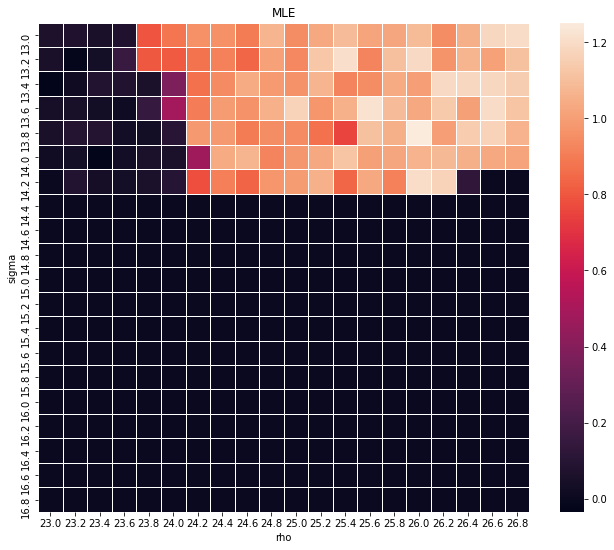

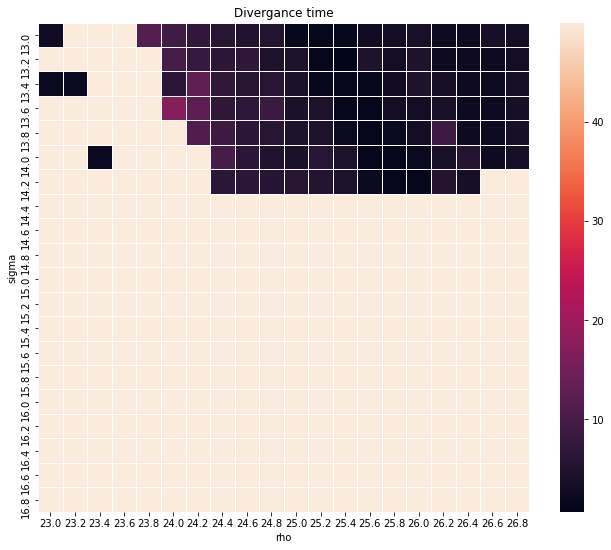

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(MLE, linewidth=0.5, xticklabels=np.around(s_Lambda, decimals=1), 
                 yticklabels=np.around(s_omega, decimals=1))
ax.set_xlabel('rho')
ax.set_ylabel('sigma')
ax.set_title('MLE')
plt.show()

fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(diverge_time, linewidth=0.5, xticklabels=np.around(s_Lambda, decimals=1), 
                 yticklabels=np.around(s_omega, decimals=1))
ax.set_xlabel('rho')
ax.set_ylabel('sigma')
ax.set_title('Divergance time')
plt.show()

In [8]:
# First convert 2D arrays to 1D arrays:
MLE_sorted = MLE[0]
diverge_time_sorted = diverge_time[0]

for i in range(s_omega.size-1):
    MLE_sorted = np.append(MLE_sorted, MLE[i+1])
    diverge_time_sorted = np.append(diverge_time_sorted, diverge_time[i+1])

# Now sort arrays from smallest to largest MLE(bubblesort):    
for i in range(MLE_sorted.size-1, 0, -1):
    for idx in range(i):
        if (MLE_sorted[idx] > MLE_sorted[idx+1]):
            temp1 = MLE_sorted[idx]
            temp2 = diverge_time_sorted[idx]
            
            MLE_sorted[idx] = MLE_sorted[idx+1]
            diverge_time_sorted[idx] = diverge_time_sorted[idx+1]
            
            MLE_sorted[idx+1] = temp1
            diverge_time_sorted[idx+1] = temp2

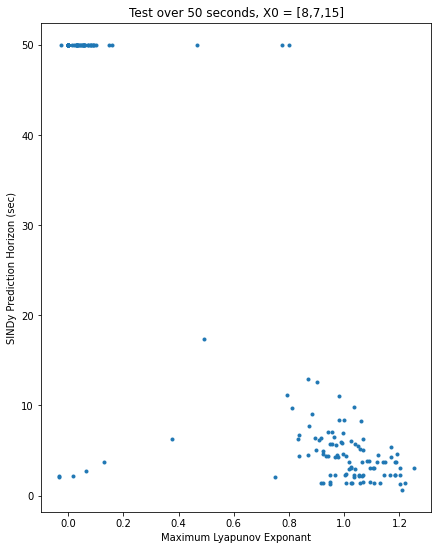

In [9]:
# Plot result
fig, axs = plt.subplots(figsize=(7, 9))

axs.plot(MLE_sorted, diverge_time_sorted,'.')
axs.set(xlabel='Maximum Lyapunov Exponant', ylabel='SINDy Prediction Horizon (sec)',
        title = 'Test over 50 seconds, X0 = [8,7,15]');



###### 